In [3]:
import sys
import os
sys.path.append(os.path.abspath('../scripts'))

from myFunctions import install_packages, save_table 
install_packages()


Installing required packages: ['numpy', 'pandas', 'scikit-learn', 'joblib', 'pyarrow', 'fastparquet', 'plotly', 'matplotlib', 'seaborn', 'MetaTrader5', 'tabulate', 'optuna', 'torch', 'tqdm', 'shap', 'kaleido', 'statsmodels', 'tqdm']
numpy is already installed.
pandas is already installed.
scikit-learn is already installed.
joblib is already installed.
pyarrow is already installed.
fastparquet is already installed.
plotly is already installed.
matplotlib is already installed.
seaborn is already installed.
MetaTrader5 is already installed.
tabulate is already installed.
optuna is already installed.
torch is already installed.
tqdm is already installed.
shap is already installed.
kaleido is already installed.
statsmodels is already installed.
tqdm is already installed.
All packages are verified.


In [50]:
from tabulate import tabulate
import pandas as pd
import numpy as np
import warnings
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from scipy.stats import norm, shapiro, normaltest


from IPython.display import display
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
from scipy.stats import skew, kurtosis



In [20]:

### folders 
input_dir_processed = os.path.join('..', 'data', 'processed')
input_dir_features = os.path.join('..', 'data', 'features')

In [71]:
M15_df_path = os.path.join(input_dir_processed, 'M15_df.parquet')
D1_df_path = os.path.join(input_dir_processed, 'D1_df.parquet')
D1_df_close_BGI = pd.read_parquet(D1_df_path)
M15_df = pd.read_parquet(M15_df_path)

In [72]:
y_cols = 'close_BGI$'
x_cols_pattern = re.compile(r'^(close_).*')
x_cols = [
    col for col in M15_df.columns
    if x_cols_pattern.match(col) and col not in y_cols
]

In [74]:
sns.set(style="whitegrid")
scaler = MinMaxScaler()
df_scaled = M15_df.copy()
for col in M15_df.columns:
    if 'close' in col:
        df_scaled[col] = scaler.fit_transform(M15_df[[col]])
df_scaled.dropna(inplace=True)

In [75]:
M15_df = M15_df[['time', 'close_BGI$']]
M15_df.set_index('time', inplace=True, drop=True)
D1_df_close_BGI = D1_df_close_BGI[['date', 'close_BGI$_1745']]
D1_df_close_BGI.set_index('date', inplace=True, drop=True)
M15_df['returns'] = M15_df['close_BGI$'].pct_change()
D1_df_close_BGI['returns'] = D1_df_close_BGI['close_BGI$_1745'].pct_change()
D1_df_close_BGI.dropna(inplace=True)
D1_df_close_BGI.dropna(inplace=True)


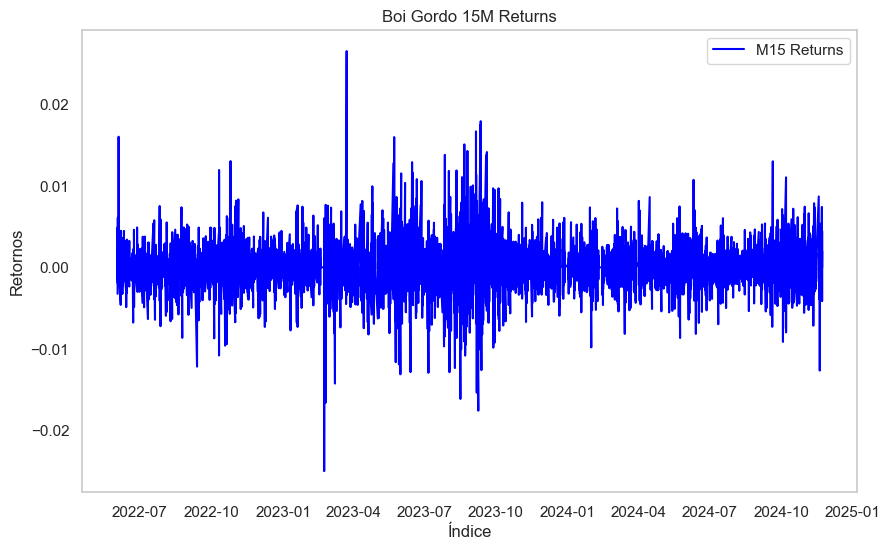

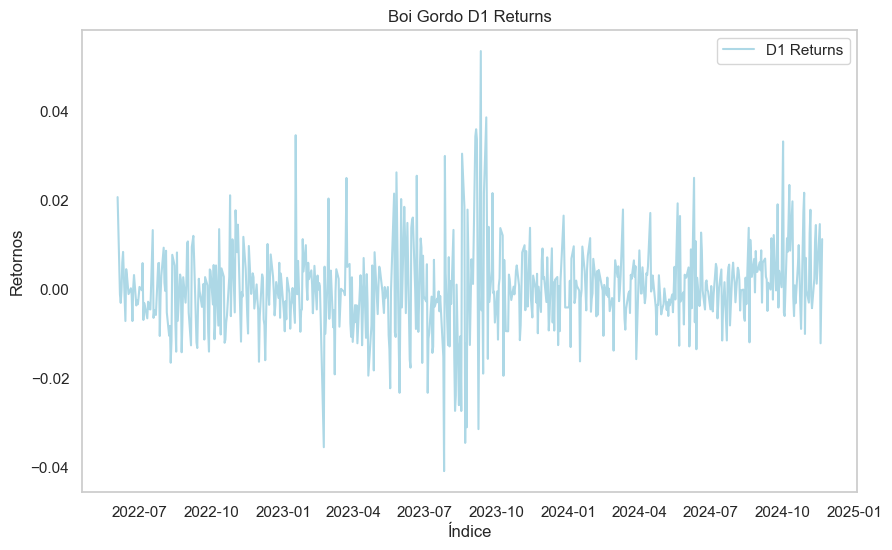

In [76]:
# Gráfico para M15_df
plt.figure(figsize=(10, 6))
plt.plot(M15_df.index, M15_df['returns'], label='M15 Returns', color='blue')
plt.title('Boi Gordo 15M Returns')
plt.xlabel('Índice')
plt.ylabel('Retornos')
plt.grid()
plt.legend()
plt.show()


# Gráfico para D1_df_close_BGI
plt.figure(figsize=(10, 6))
plt.plot(D1_df_close_BGI.index, D1_df_close_BGI['returns'], label='D1 Returns', color='lightblue')
plt.title('Boi Gordo D1 Returns')
plt.xlabel('Índice')
plt.ylabel('Retornos')
plt.grid()
plt.legend()
plt.show()

In [77]:
# Para M15_df
max_return_date_M15 = M15_df['returns'].idxmax()
max_return_value_M15 = M15_df['returns'].max()
min_return_date_M15 = M15_df['returns'].idxmin()
min_return_value_M15 = M15_df['returns'].min()

# Para D1_df_close_BGI
max_return_date_D1 = D1_df_close_BGI['returns'].idxmax()
max_return_value_D1 = D1_df_close_BGI['returns'].max()
min_return_date_D1 = D1_df_close_BGI['returns'].idxmin()
min_return_value_D1 = D1_df_close_BGI['returns'].min()


print("M15_df Results:")
display(f"Max Return: {max_return_value_M15} on {max_return_date_M15}")
display(f"Min Return: {min_return_value_M15} on {min_return_date_M15}")

print("\nD1_df_close_BGI Results:")
display(f"Max Return: {max_return_value_D1} on {max_return_date_D1}")
display(f"Min Return: {min_return_value_D1} on {min_return_date_D1}")


M15_df Results:


'Max Return: 0.026528504789374407 on 2023-03-23 09:00:00'

'Min Return: -0.024994081239219534 on 2023-02-22 13:00:00'


D1_df_close_BGI Results:


'Max Return: 0.0536396724294812 on 2023-09-11'

'Min Return: -0.04081800262812085 on 2023-07-26'

In [78]:
D1_df_close_BGI.dropna(inplace=True)
M15_df.dropna(inplace=True)

# Calcular a assimetria e a curtose
skewness = skew(D1_df_close_BGI['returns'])
kurt = kurtosis(D1_df_close_BGI['returns'])

print(f"Assimetria: {skewness}")
print(f"Curtose: {kurt}")

skewness = skew(M15_df['returns'])
kurt = kurtosis(M15_df['returns'])

print(f"Assimetria: {skewness}")
print(f"Curtose: {kurt}")


Assimetria: 0.4380212004410425
Curtose: 3.102264701156783
Assimetria: 0.27595932779174065
Curtose: 19.569526970371815


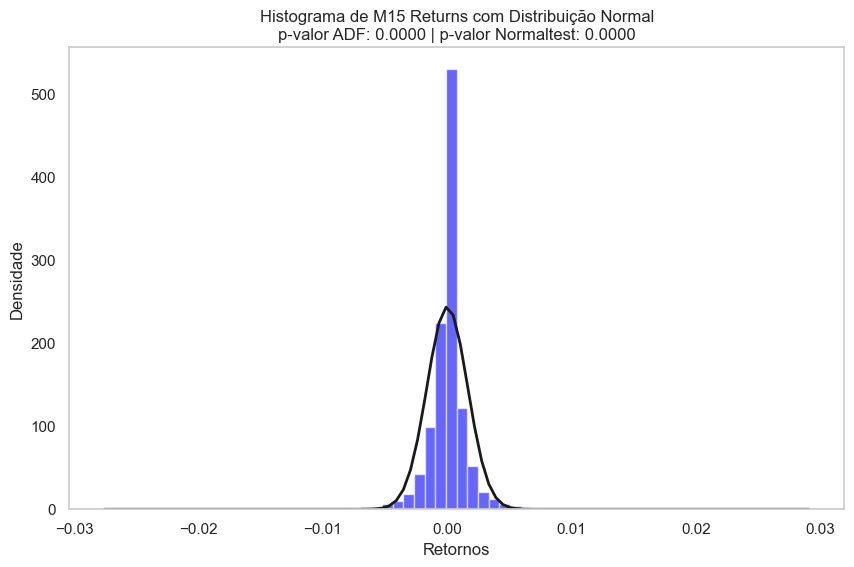

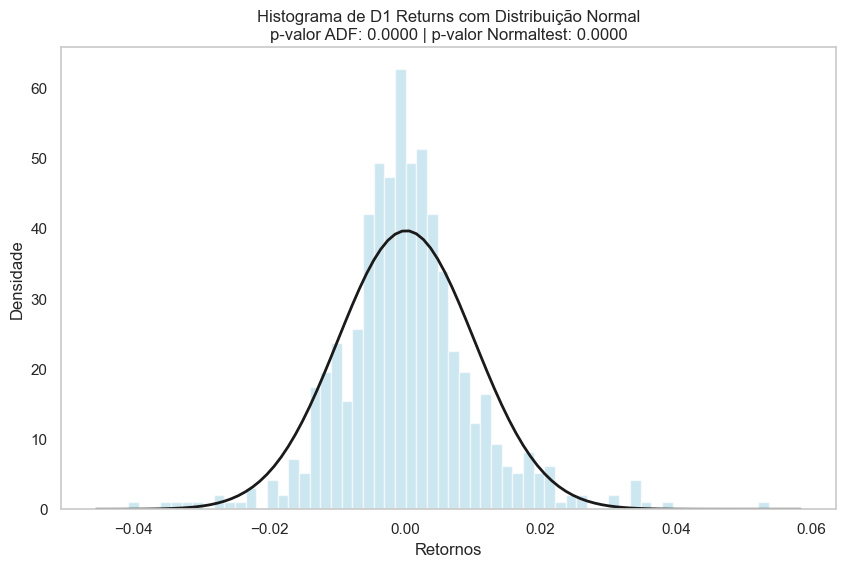

In [79]:
# Gráfico para M15_df com mais bins
plt.figure(figsize=(10, 6))
plt.hist(M15_df['returns'].dropna(), bins=60, density=True, alpha=0.6, color='blue')  # Aumentei para 30 bins
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(M15_df['returns'].dropna()), np.std(M15_df['returns'].dropna()))
plt.plot(x, p, 'k', linewidth=2)
adf_result = adfuller(M15_df['returns'].dropna())
adf_p_value = adf_result[1]
normaltest_stat, normaltest_p_value = normaltest(M15_df['returns'].dropna())
plt.title(f'Histograma de M15 Returns com Distribuição Normal\np-valor ADF: {adf_p_value:.4f} | p-valor Normaltest: {normaltest_p_value:.4f}')
plt.xlabel('Retornos')
plt.ylabel('Densidade')
plt.grid()
plt.show()

# Gráfico para D1_df_close_BGI com mais bins
plt.figure(figsize=(10, 6))
plt.hist(D1_df_close_BGI['returns'].dropna(), bins=60, density=True, alpha=0.6, color='lightblue')  # Aumentei para 30 bins
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(D1_df_close_BGI['returns'].dropna()), np.std(D1_df_close_BGI['returns'].dropna()))
plt.plot(x, p, 'k', linewidth=2)
adf_result = adfuller(D1_df_close_BGI['returns'].dropna())
adf_p_value = adf_result[1]
normaltest_stat, normaltest_p_value = normaltest(D1_df_close_BGI['returns'].dropna())
plt.title(f'Histograma de D1 Returns com Distribuição Normal\np-valor ADF: {adf_p_value:.4f} | p-valor Normaltest: {normaltest_p_value:.4f}')
plt.xlabel('Retornos')
plt.ylabel('Densidade')
plt.grid()
plt.show()


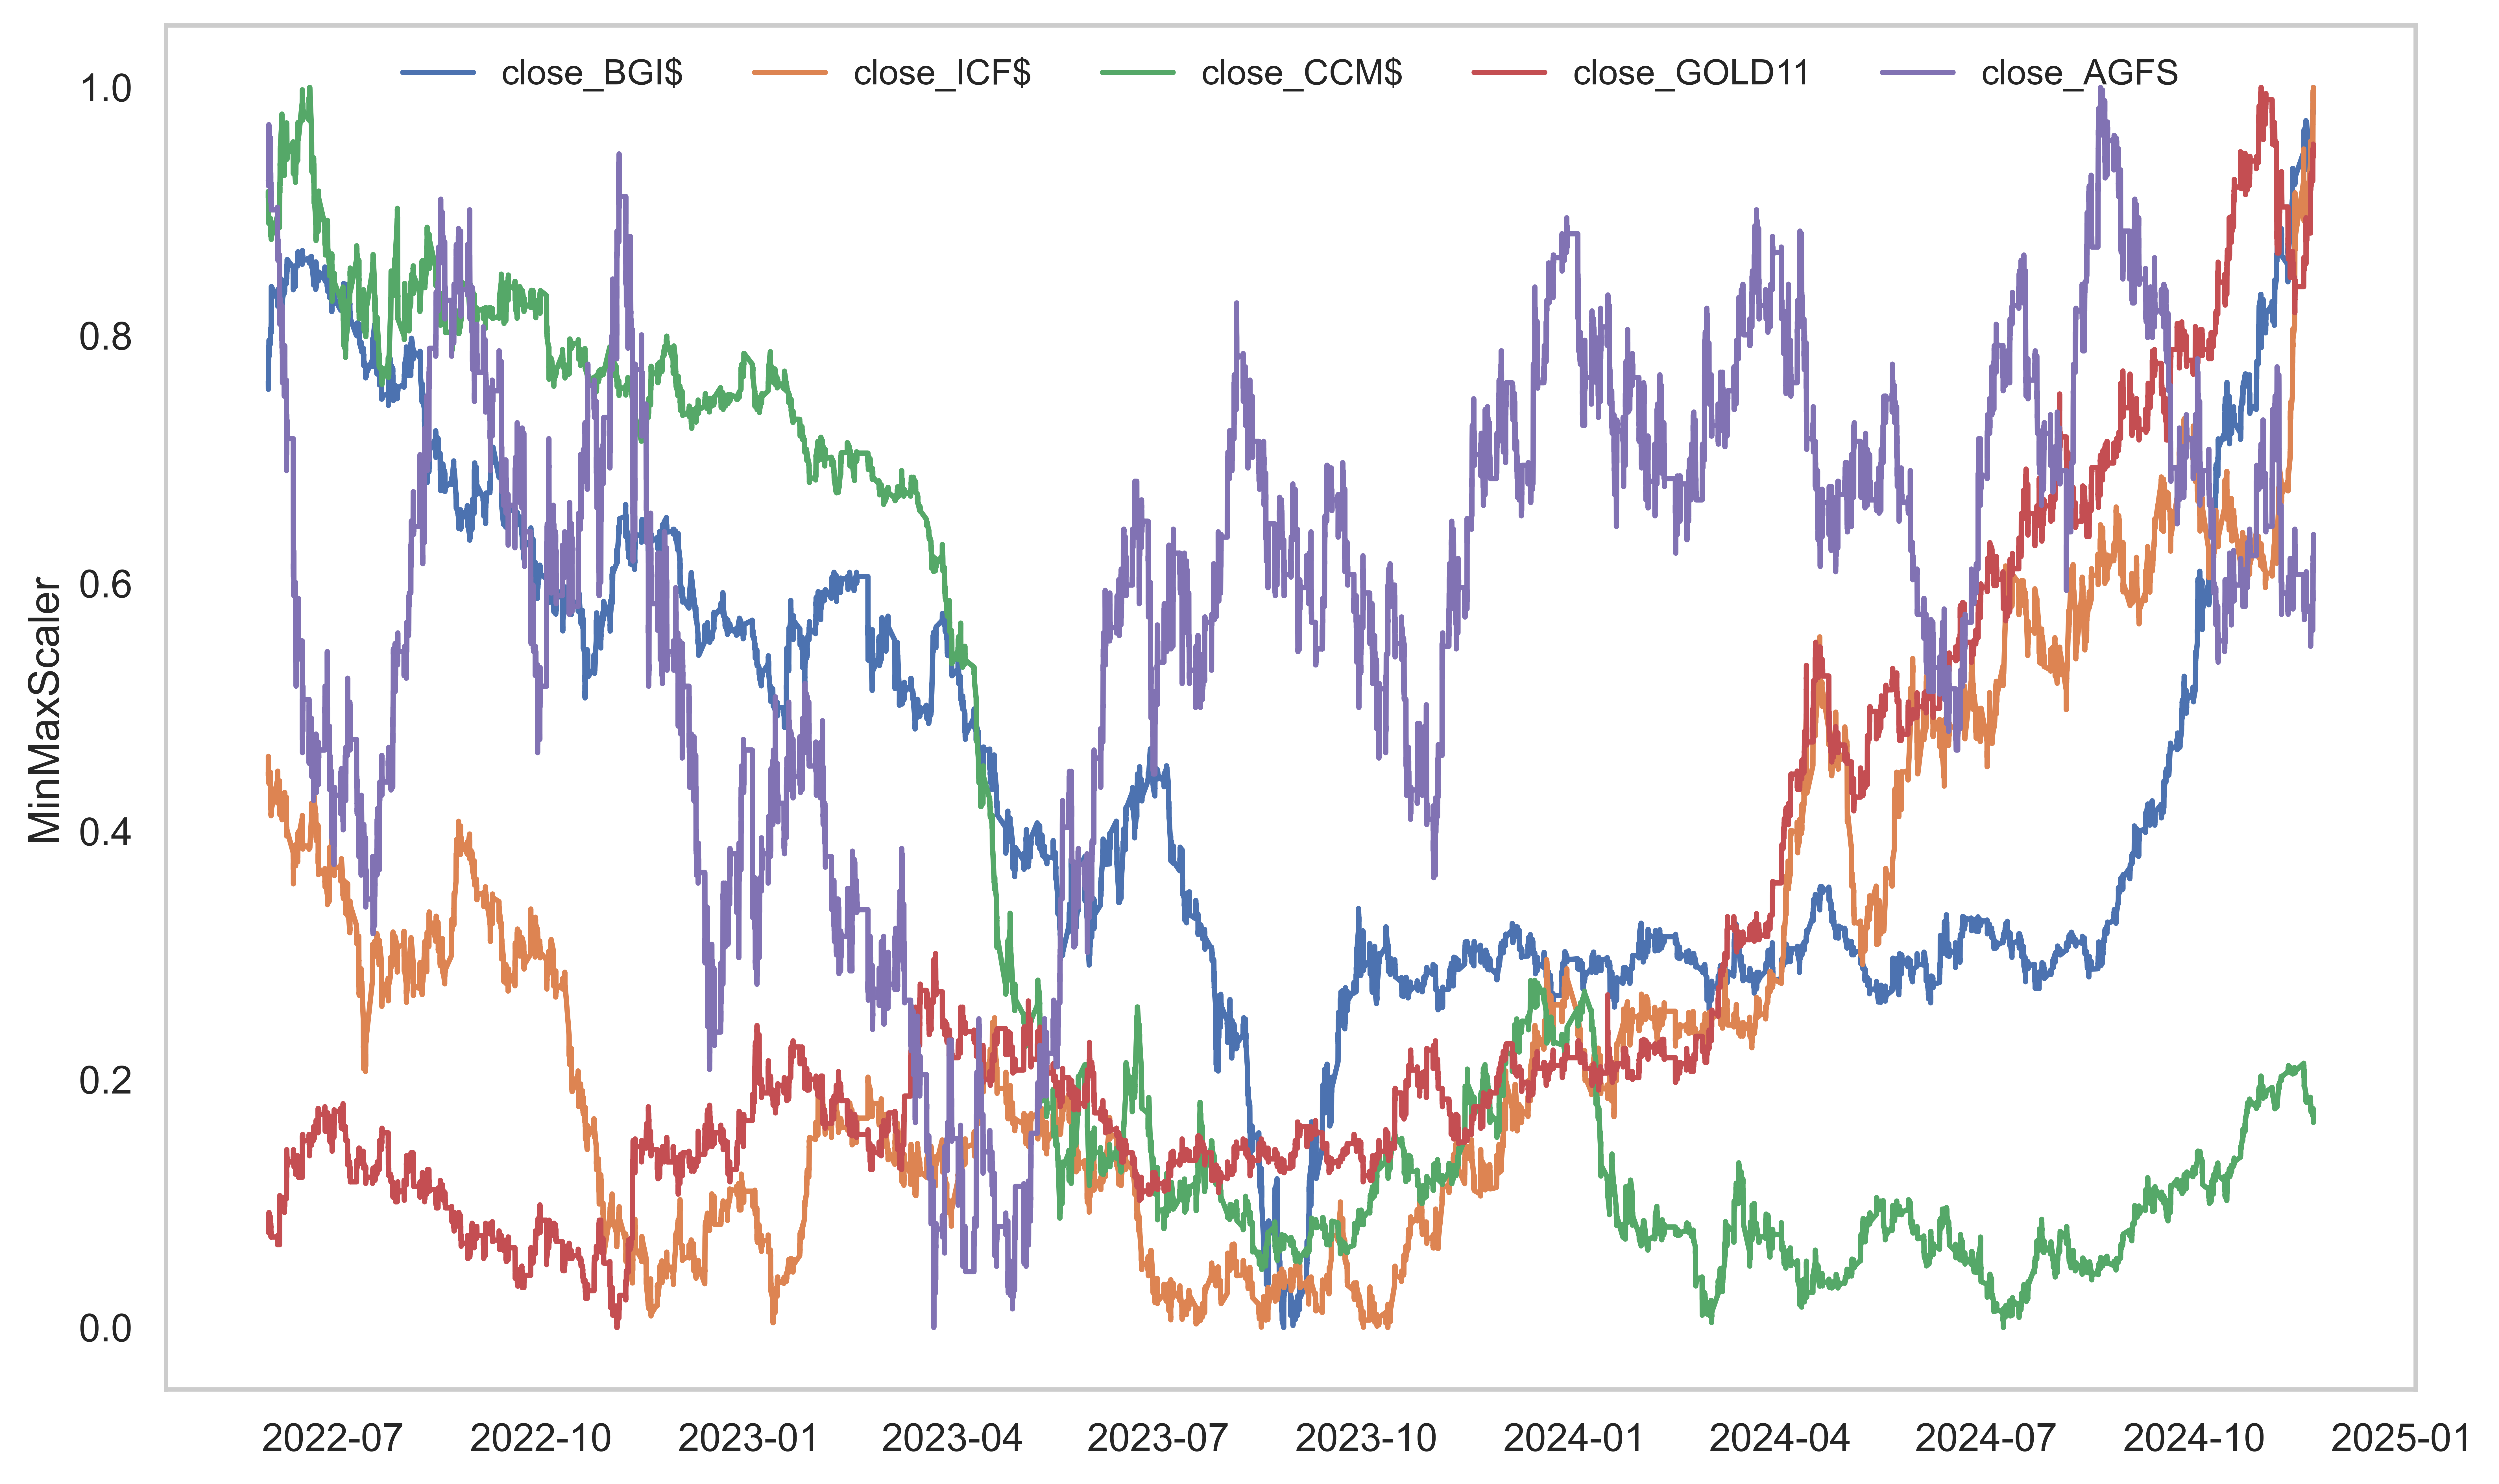

In [80]:
sns.set(style="whitegrid")
close_cols = ['close_BGI$', 'close_ICF$', 'close_CCM$', 'close_GOLD11', 'close_AGFS']
plt.figure(figsize=(10, 6), dpi=900)  # Aumentando a resolução e o tamanho
for col in close_cols:
    plt.plot(df_scaled.time, df_scaled[col], label=col)
plt.ylabel('MinMaxScaler', fontsize=12)
plt.grid(False)
plt.legend(
    bbox_to_anchor=(0.5, 1),  # Posicionar abaixo
    loc='upper center',
    ncol=5,  # Distribuir em 4 colunas
    fontsize=10,
   
    frameon=False
)
plt.tight_layout()
plt.show()


In [81]:
def adfuller_test(df, critical_level='5%'):
    # Check if the critical level is valid
    if critical_level not in ['1%', '5%', '10%']:
        raise ValueError("The critical_level parameter must be one of: '1%', '5%', or '10%'")

    non_stationary = []  # List to store non-stationary variables
    result_df = pd.DataFrame(columns=['Variable', 'ADF Statistic', 'p-value', '1%', '5%', '10%', 'res'])

    # Loop through each column (variable)
    for col in df.columns:
        result = adfuller(df[col].values)
        adf_stat = result[0]
        p_value = result[1]
        critical_vals = result[4]

        # Compare the ADF statistic with the selected critical value
        is_stationary = 1 if adf_stat < critical_vals[critical_level] else 0

        # Append to the non_stationary list if not stationary
        if is_stationary == 0:
            non_stationary.append(col)
        
        # Collect results for each variable
        row = {
            'Variable': col,
            'ADF Statistic': adf_stat,
            'p-value': p_value,
            '1%': critical_vals['1%'],
            '5%': critical_vals['5%'],
            '10%': critical_vals['10%'],
            'res': is_stationary  # 1 for Stationary, 0 for Non-Stationary
        }
        print(row)
        # Append row to result_df
        result_df = pd.concat([result_df, pd.DataFrame([row])], ignore_index=True)

    # Return non_stationary variables and result_df
    return non_stationary, result_df

In [82]:
def make_stationary(df: pd.DataFrame(), 
                    max_diffs: int = 5):
    """
    Make the given dataframe stationary by applying differencing.

    Args:
        df (pd.DataFrame): DataFrame containing time series data.
        max_diffs (int): Maximum number of differencing iterations to perform.

    Returns:
        pd.DataFrame: DataFrame with columns showing the stationarity status after each differencing iteration.
    """

    diff_df = df.copy()
    result_df = pd.DataFrame(index=df.columns)  # Start with columns as index for results
    stationary_set = set()
    diff_counts = {col: 0 for col in df.columns}  # Track number of differencing for each column

    for i in range(max_diffs):
        # Perform differencing only if it's not the first iteration
        if i != 0:
            diff_df = diff_df.diff()
            diff_df.dropna(inplace=True)
        
        non_stationary_cols, current_result_df = adfuller_test(diff_df)
        
        # Update stationary columns
        stationary_set.update([col for col in df.columns if col not in non_stationary_cols])
        
        # Track how many times each column needed differencing
        for col in df.columns:
            if col in stationary_set:
                diff_counts[col] = i  # Mark the number of differences for stationary columns

        # If all columns are stationary, break the loop
        if len(stationary_set) == len(df.columns):
            break
        
        # Only keep non-stationary columns for the next iteration
        diff_df = diff_df[non_stationary_cols]

    # Update result_df with diff_counts
    result_df['diff'] = result_df.index.map(diff_counts)
    
    return result_df


In [83]:
def johansen_cointegration_test(data, det_order=-1, k_ar_diff=0, critical_level="5%"):
    """
    Perform the Johansen cointegration test for a given data window and return the test results.
    
    Parameters:
    ----------
    data : pd.DataFrame
        Data for which the cointegration test should be performed.
    det_order : int
        The deterministic trend assumption in the Johansen test (-1 for no trend).
    k_ar_diff : int
        The number of lags to use in the differenced series.
    critical_level : str
        The critical level for determining cointegration ('1%', '5%', '10%').
    
    Returns:
    -------
    dict
        A dictionary with the cointegration results (whether cointegração was found, and rankings).
    """
    # Map critical level to index for accessing critical values
    col = {'1%': 0, '5%': 1, '10%': 2}.get(critical_level)
    if col is None:
        raise ValueError("Critical level must be '1%', '5%' or '10%'.")

    # Run Johansen cointegration test
    johansen_result = coint_johansen(data, det_order=det_order, k_ar_diff=k_ar_diff)

    # Extract results
    trace_stats = johansen_result.lr1
    max_eigen_stats = johansen_result.lr2
    trace_critical_vals = johansen_result.cvt
    max_eigen_critical_vals = johansen_result.cvm

    # Determine cointegration and rankings based on trace and max eigenvalue
    trace_cointegration = int(any(trace_stats[i] >= trace_critical_vals[i][col] for i in range(len(trace_stats))))
    max_eigen_cointegration = int(any(max_eigen_stats[i] >= max_eigen_critical_vals[i][col] for i in range(len(max_eigen_stats))))

    return {
        "cointegration_trace": trace_cointegration,
        "cointegration_max_eigen": max_eigen_cointegration,
        "trace_ranking": sum(trace_stats[i] >= trace_critical_vals[i][col] for i in range(len(trace_stats))),
        "max_eigen_ranking": sum(max_eigen_stats[i] >= max_eigen_critical_vals[i][col] for i in range(len(max_eigen_stats))),
        "eigenvalues": johansen_result.eig
    }

def sliding_johansen_cointegration(df, y_var, coint_vars, window_size=30, max_cols=3, det_order=-1, k_ar_diff=0, critical_level="5%"):
    from itertools import combinations
    import pandas as pd
    from tqdm import tqdm

    comb_vars = [list(combinations(coint_vars, i)) for i in range(1, max_cols + 1)]
    combined_columns = []
    for comb_set in comb_vars:
        for comb in comb_set:
            combined_columns.append((y_var, *comb))

    # Lista para acumular resultados
    coint_list = []

    # Iterar sobre combinações de variáveis
    for comb in tqdm(combined_columns):
        print(f'Combination: {comb}')
        data = df[list(comb)]  # Seleciona os dados de ambas as variáveis do par
        start = 0
        while start + window_size <= len(df):
            end = start + window_size
            window_data = data.iloc[start:end]
            start_date = window_data.index.min()
            end_date = window_data.index.max()
            
            print(f'Checking coint for {start_date} to {end_date}')
            coint_df = johansen_cointegration_test(window_data, det_order, k_ar_diff, critical_level)

            if coint_df['cointegration_trace'] == 1 or coint_df['cointegration_max_eigen'] == 1:
                # Expandindo o intervalo enquanto houver cointegração
                last_cointegrated = coint_df
                while end + window_size <= len(df):
                    expanded_end = end + window_size
                    expanded_data = data.iloc[start:expanded_end]
                    expanded_end_date = expanded_data.index.max()

                    print(f'Expanding coint check: {start_date} to {expanded_end_date}')
                    expanded_coint_df = johansen_cointegration_test(expanded_data, det_order, k_ar_diff, critical_level)

                    if expanded_coint_df['cointegration_trace'] == 1 or expanded_coint_df['cointegration_max_eigen'] == 1:
                        last_cointegrated = expanded_coint_df
                        end = expanded_end
                    else:
                        break

                # Registrar o último intervalo cointegrado
                coint_list.append({
                    "Start Date": start_date,
                    "End Date": data.iloc[start:end].index.max(),
                    "Cointegrated Variables": ', '.join(str(var) for var in comb),
                    "Cointegration (Trace)": last_cointegrated['cointegration_trace'],
                    "Ranking (Trace)": last_cointegrated['trace_ranking'],
                    "Cointegration (Max Eigenvalue)": last_cointegrated['cointegration_max_eigen'],
                    "Ranking (Max Eigenvalue)": last_cointegrated['max_eigen_ranking'],
                    "Eigenvalues": last_cointegrated['eigenvalues']
                })

                # Atualizar início para o fim do último intervalo cointegrado
                start = end
            else:
                # Sem cointegração, avançar para o próximo intervalo
                start += window_size

    coint_df = pd.DataFrame(coint_list)
    return coint_df


def plot_correlation_matrix(df):
    """
    Function to plot the correlation matrix between the variables in a DataFrame.

    Parameters:
    df (DataFrame): The DataFrame containing the numerical variables.
    """
    # Calculate the correlation matrix
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    np.fill_diagonal(mask, False)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True, 
                linewidths=0.5, mask=mask, linecolor='white')
    plt.grid(False)
    plt.title('Correlation Heatmap')
    plt.show()


def calculate_autocorrelation(df):
    """
    Function that calculates the temporal autocorrelation for all columns in a DataFrame.
    """
    # Initialize the plot
    plt.figure(figsize=(12, 8))

    # Calculate and plot the autocorrelation for each column
    for i, column in enumerate(df.columns):
        acf_vals, confint = acf(df[column], nlags=40, alpha=0.05)
        plt.subplot(len(df.columns), 1, i+1)
        plt.stem(acf_vals)  # Removed 'use_line_collection'
        plt.title(f'Autocorrelation of {column}')
        plt.xlabel('Lags')
        plt.ylabel('Autocorrelation')

        plt.tight_layout()
        plt.show()


C:\Users\guitz\AppData\Local\Temp\ipykernel_12568\2633754273.py:149: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


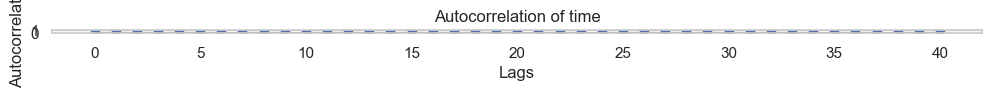

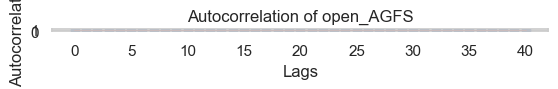

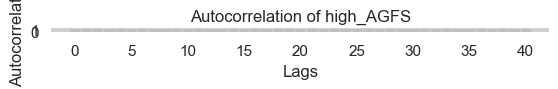

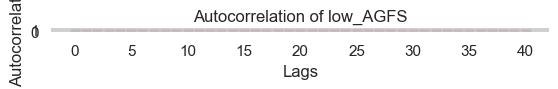

KeyboardInterrupt: 

In [84]:
calculate_autocorrelation(df_scaled)

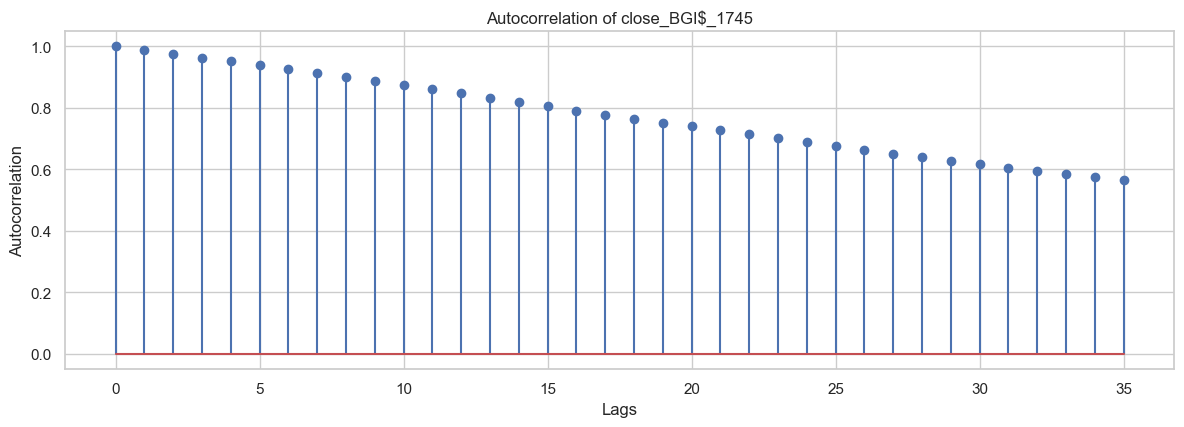

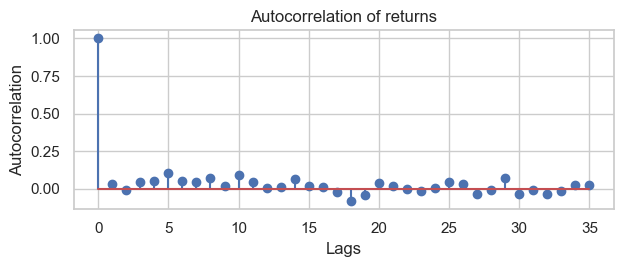

In [65]:
calculate_autocorrelation(D1_df_close_BGI)

In [85]:
df_scaled.columns

Index(['time', 'open_AGFS', 'high_AGFS', 'low_AGFS', 'close_AGFS',
       'tick_volume_AGFS', 'spread_AGFS', 'real_volume_AGFS', 'open_BGI$',
       'high_BGI$',
       ...
       'EMA55_GOLD11', 'EMA9_IBOV', 'EMA21_IBOV', 'EMA55_IBOV', 'EMA9_DOL$',
       'EMA21_DOL$', 'EMA55_DOL$', 'close_price_target', 'open_price_target',
       'behavior_target'],
      dtype='object', length=172)

In [33]:
df_scaled.set_index('time', inplace= True, drop=True)


In [34]:
non_stationary, result_df = adfuller_test(df_scaled)

{'Variable': 'open_AGFS', 'ADF Statistic': -2.801179168440909, 'p-value': 0.058105529563907056, '1%': -3.430642593555084, '5%': -2.861669316817462, '10%': -2.566838831678198, 'res': 0}
{'Variable': 'high_AGFS', 'ADF Statistic': -2.8287518972930434, 'p-value': 0.05428268173478589, '1%': -3.4306431575862364, '5%': -2.861669566088544, '10%': -2.566838964360272, 'res': 0}
{'Variable': 'low_AGFS', 'ADF Statistic': -2.831220885307616, 'p-value': 0.053950619996393175, '1%': -3.4306431313040147, '5%': -2.861669554473233, '10%': -2.566838958177671, 'res': 0}
{'Variable': 'close_AGFS', 'ADF Statistic': -2.7625523511214327, 'p-value': 0.06382519388000094, '1%': -3.4306426066474365, '5%': -2.86166932260357, '10%': -2.566838834758029, 'res': 0}
{'Variable': 'tick_volume_AGFS', 'ADF Statistic': -14.893789441005014, 'p-value': 1.5431855033686442e-27, '1%': -3.4306431838731717, '5%': -2.861669577705938, '10%': -2.566838970543982, 'res': 1}


ValueError: Invalid input, x is constant

In [86]:
df_sta = make_stationary(df_scaled)

{'Variable': 'time', 'ADF Statistic': 20.895398322532085, 'p-value': 1.0, '1%': -3.4306431838731717, '5%': -2.861669577705938, '10%': -2.566838970543982, 'res': 0}
{'Variable': 'open_AGFS', 'ADF Statistic': -2.801179168440909, 'p-value': 0.058105529563907056, '1%': -3.430642593555084, '5%': -2.861669316817462, '10%': -2.566838831678198, 'res': 0}
{'Variable': 'high_AGFS', 'ADF Statistic': -2.8287518972930434, 'p-value': 0.05428268173478589, '1%': -3.4306431575862364, '5%': -2.861669566088544, '10%': -2.566838964360272, 'res': 0}
{'Variable': 'low_AGFS', 'ADF Statistic': -2.831220885307616, 'p-value': 0.053950619996393175, '1%': -3.4306431313040147, '5%': -2.861669554473233, '10%': -2.566838958177671, 'res': 0}
{'Variable': 'close_AGFS', 'ADF Statistic': -2.7625523511214327, 'p-value': 0.06382519388000094, '1%': -3.4306426066474365, '5%': -2.86166932260357, '10%': -2.566838834758029, 'res': 0}
{'Variable': 'tick_volume_AGFS', 'ADF Statistic': -14.893789441005014, 'p-value': 1.5431855033

ValueError: Invalid input, x is constant

In [333]:
df_sta

,diff
close_BGI$,1
close_AGFS,1
close_CCM$,1
close_DI1$,1
close_DOL$,1
close_GOLD11,1
close_IBOV,1
close_ICF$,1
close_ICON,1
close_IFIX,1


In [334]:
save_table(result_df,title='Teste de estacionariedade para preço de fechamento na primeira diferença')

Table saved as CSV: ..\results\tables\csv\Tabela_4_Teste de estacionariedade para preço de fechamento na primeira diferença.csv


In [335]:
save_table(df_sta,title='Quantidade de diferenciações do preço de fechamento para estacionariedade ')

Table saved as CSV: ..\results\tables\csv\Tabela_5_Quantidade de diferenciações do preço de fechamento para estacionariedade .csv


In [45]:
continuous_coint_df = sliding_johansen_cointegration(df_scaled, y_var= y_cols, 
                                       coint_vars=x_cols,
                                       window_size=1050, 
                                       max_cols=1)

continuous_coint_df

# Convertendo as colunas para o formato datetime
continuous_coint_df["Start Date"] = pd.to_datetime(continuous_coint_df["Start Date"], format="%d/%m/%Y %H:%M")
continuous_coint_df["End Date"] = pd.to_datetime(continuous_coint_df["End Date"], format="%d/%m/%Y %H:%M")

# Calculando a diferença em dias
continuous_coint_df["Difference in Days"] = (continuous_coint_df["End Date"] - continuous_coint_df["Start Date"]).dt.days

# Calculando a diferença em meses aproximados
continuous_coint_df["Difference in Months"] = continuous_coint_df["Difference in Days"] / 30.4375




 17%|█▋        | 2/12 [00:00<00:00, 15.38it/s]

Combination: ('close_BGI$', 'close_AGFS')
Checking coint for 2022-06-02 09:00:00 to 2022-07-14 10:15:00
Checking coint for 2022-07-14 10:30:00 to 2022-08-24 11:45:00
Checking coint for 2022-08-24 12:00:00 to 2022-10-05 13:15:00
Checking coint for 2022-10-05 13:30:00 to 2022-11-18 14:45:00
Checking coint for 2022-11-18 15:00:00 to 2022-12-29 16:15:00
Checking coint for 2022-12-29 16:30:00 to 2023-02-09 17:45:00
Checking coint for 2023-02-10 09:00:00 to 2023-03-27 10:15:00
Checking coint for 2023-03-27 10:30:00 to 2023-05-10 11:45:00
Checking coint for 2023-05-10 12:00:00 to 2023-06-21 13:15:00
Checking coint for 2023-06-21 13:30:00 to 2023-08-01 14:45:00
Checking coint for 2023-08-01 15:00:00 to 2023-09-12 16:15:00
Checking coint for 2023-09-12 16:30:00 to 2023-10-24 17:45:00
Checking coint for 2023-10-25 09:00:00 to 2023-12-07 10:15:00
Checking coint for 2023-12-07 10:30:00 to 2024-01-22 11:45:00
Checking coint for 2024-01-22 12:00:00 to 2024-03-05 13:15:00
Checking coint for 2024-03-0

 33%|███▎      | 4/12 [00:00<00:00, 14.98it/s]

Checking coint for 2024-07-10 09:00:00 to 2024-08-20 10:15:00
Checking coint for 2024-08-20 10:30:00 to 2024-09-30 11:45:00
Expanding coint check: 2024-08-20 10:30:00 to 2024-11-08 13:15:00
Combination: ('close_BGI$', 'close_DOL$')
Checking coint for 2022-06-02 09:00:00 to 2022-07-14 10:15:00
Checking coint for 2022-07-14 10:30:00 to 2022-08-24 11:45:00
Checking coint for 2022-08-24 12:00:00 to 2022-10-05 13:15:00
Checking coint for 2022-10-05 13:30:00 to 2022-11-18 14:45:00
Checking coint for 2022-11-18 15:00:00 to 2022-12-29 16:15:00
Expanding coint check: 2022-11-18 15:00:00 to 2023-02-09 17:45:00
Checking coint for 2022-12-29 16:30:00 to 2023-02-09 17:45:00
Checking coint for 2023-02-10 09:00:00 to 2023-03-27 10:15:00
Checking coint for 2023-03-27 10:30:00 to 2023-05-10 11:45:00
Checking coint for 2023-05-10 12:00:00 to 2023-06-21 13:15:00
Checking coint for 2023-06-21 13:30:00 to 2023-08-01 14:45:00
Checking coint for 2023-08-01 15:00:00 to 2023-09-12 16:15:00
Checking coint for 2

 75%|███████▌  | 9/12 [00:00<00:00, 17.97it/s]

Checking coint for 2024-09-30 12:00:00 to 2024-11-08 13:15:00
Combination: ('close_BGI$', 'close_ICON')
Checking coint for 2022-06-02 09:00:00 to 2022-07-14 10:15:00
Checking coint for 2022-07-14 10:30:00 to 2022-08-24 11:45:00
Checking coint for 2022-08-24 12:00:00 to 2022-10-05 13:15:00
Expanding coint check: 2022-08-24 12:00:00 to 2022-11-18 14:45:00
Checking coint for 2022-10-05 13:30:00 to 2022-11-18 14:45:00
Checking coint for 2022-11-18 15:00:00 to 2022-12-29 16:15:00
Checking coint for 2022-12-29 16:30:00 to 2023-02-09 17:45:00
Checking coint for 2023-02-10 09:00:00 to 2023-03-27 10:15:00
Checking coint for 2023-03-27 10:30:00 to 2023-05-10 11:45:00
Checking coint for 2023-05-10 12:00:00 to 2023-06-21 13:15:00
Checking coint for 2023-06-21 13:30:00 to 2023-08-01 14:45:00
Checking coint for 2023-08-01 15:00:00 to 2023-09-12 16:15:00
Checking coint for 2023-09-12 16:30:00 to 2023-10-24 17:45:00
Checking coint for 2023-10-25 09:00:00 to 2023-12-07 10:15:00
Checking coint for 2023-

c:\Users\guitz\anaconda3\envs\pytorch_env\lib\site-packages\statsmodels\tsa\vector_ar\vecm.py:730: RuntimeWarning: invalid value encountered in log
  tmp = np.log(iota - a)[i:]
c:\Users\guitz\anaconda3\envs\pytorch_env\lib\site-packages\statsmodels\tsa\vector_ar\vecm.py:732: RuntimeWarning: invalid value encountered in log
  lr2[i] = -t * np.log(1 - a[i])
100%|██████████| 12/12 [00:00<00:00, 16.62it/s]

Checking coint for 2022-06-02 09:00:00 to 2022-07-14 10:15:00
Checking coint for 2022-07-14 10:30:00 to 2022-08-24 11:45:00
Checking coint for 2022-08-24 12:00:00 to 2022-10-05 13:15:00
Expanding coint check: 2022-08-24 12:00:00 to 2022-11-18 14:45:00
Checking coint for 2022-10-05 13:30:00 to 2022-11-18 14:45:00
Expanding coint check: 2022-10-05 13:30:00 to 2022-12-29 16:15:00
Expanding coint check: 2022-10-05 13:30:00 to 2023-02-09 17:45:00
Expanding coint check: 2022-10-05 13:30:00 to 2023-03-27 10:15:00
Checking coint for 2023-02-10 09:00:00 to 2023-03-27 10:15:00
Checking coint for 2023-03-27 10:30:00 to 2023-05-10 11:45:00
Expanding coint check: 2023-03-27 10:30:00 to 2023-06-21 13:15:00
Checking coint for 2023-05-10 12:00:00 to 2023-06-21 13:15:00
Checking coint for 2023-06-21 13:30:00 to 2023-08-01 14:45:00
Expanding coint check: 2023-06-21 13:30:00 to 2023-09-12 16:15:00
Checking coint for 2023-08-01 15:00:00 to 2023-09-12 16:15:00
Expanding coint check: 2023-08-01 15:00:00 to 

In [49]:
save_table(continuous_coint_df, title='Intervalos cointegrados para Boi Gordo e as demais variaveis explicativas')

Table saved as CSV: ..\results\tables\csv\Tabela_8_Intervalos cointegrados para Boi Gordo e as demais variaveis explicativas.csv


In [48]:
continuous_coint_df.head(50)

,Start Date,End Date,Cointegrated Variables,Cointegration (Trace),Ranking (Trace),Cointegration (Max Eigenvalue),Ranking (Max Eigenvalue),Eigenvalues,Difference in Days,Difference in Months
0,2024-03-05 13:30:00,2024-04-16 14:45:00,"close_BGI$, close_AGFS",0,0,1,1,"[0.011030326645072534, 0.00015414588348382566]",42,1.379877
1,2024-09-30 12:00:00,2024-11-08 13:15:00,"close_BGI$, close_AGFS",1,1,1,1,"[0.01116864628680842, 0.0015218567243479725]",39,1.281314
2,2023-03-27 10:30:00,2023-05-10 11:45:00,"close_BGI$, close_CCM$",1,1,1,1,"[0.013484003453734022, 0.0022118177544526215]",44,1.445585
3,2024-08-20 10:30:00,2024-11-08 13:15:00,"close_BGI$, close_CCM$",1,2,1,2,"[0.011981662092352994, 0.002215946198601231]",80,2.628337
4,2023-02-10 09:00:00,2023-03-27 10:15:00,"close_BGI$, close_DI1$",1,1,1,1,"[0.010849651383328381, 0.000981627753627732]",45,1.478439
5,2024-03-05 13:30:00,2024-04-16 14:45:00,"close_BGI$, close_DI1$",1,1,1,1,"[0.020389260086995355, 0.0004044680443124754]",42,1.379877
6,2024-08-20 10:30:00,2024-11-08 13:15:00,"close_BGI$, close_DI1$",1,1,1,1,"[0.010779917775552761, 0.0007909575073496277]",80,2.628337
7,2022-11-18 15:00:00,2022-12-29 16:15:00,"close_BGI$, close_DOL$",1,1,1,1,"[0.012991199500446571, 0.0003636494158174054]",41,1.347023
8,2024-01-22 12:00:00,2024-04-16 14:45:00,"close_BGI$, close_DOL$",1,1,1,1,"[0.013025733122230595, 0.0002301545305128279]",85,2.792608
9,2024-09-30 12:00:00,2024-11-08 13:15:00,"close_BGI$, close_DOL$",1,2,1,2,"[0.012776358887456894, 0.006644416080446622]",39,1.281314


In [324]:
# input_dir = os.path.join('..', 'data', 'hyperparameters', 'daily','CNN-LSTM_look_back_45_look_forward_1_behavior_target', 'CNN-LSTM_look_back_45_look_forward_1_behavior_target_study.pkl' )
df_scaled.set_index('time', inplace=True, drop=True)

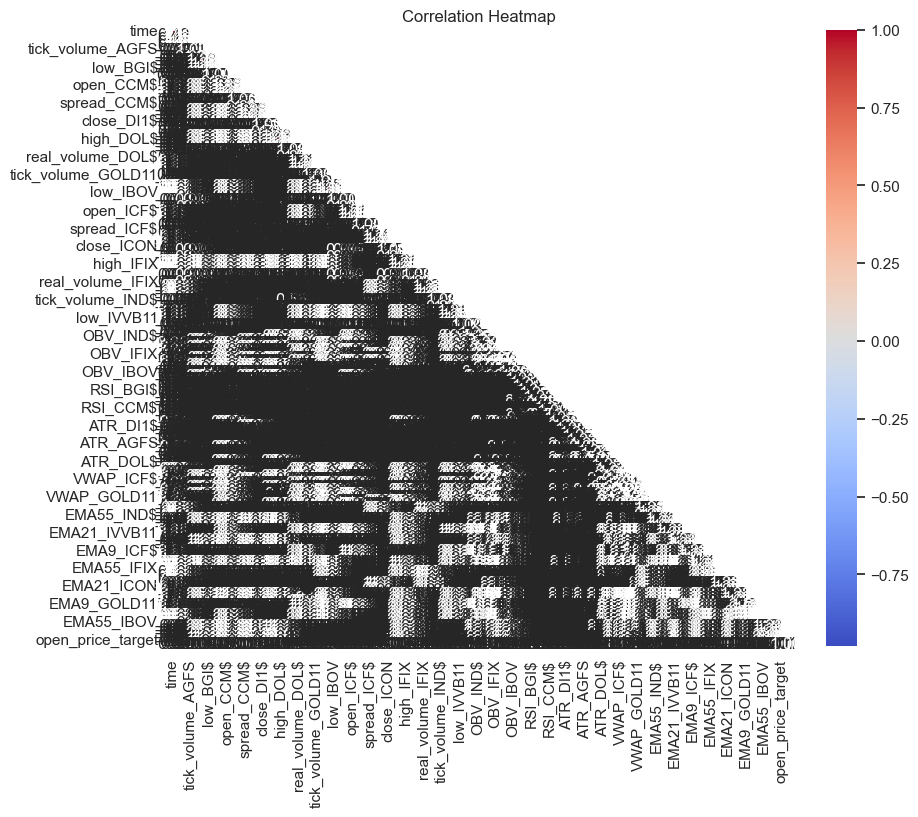

In [91]:
plot_correlation_matrix(df_scaled)

In [92]:
close_columns = [
    'close_AGFS', 'close_BGI$', 'close_CCM$', 'close_DI1$', 'close_DOL$', 
    'close_GOLD11', 'close_IBOV', 'close_ICF$', 'close_ICON', 'close_IFIX', 
    'close_IND$', 'close_IVVB11'
]

tick_volume_columns = ['close_BGI$',
    'tick_volume_AGFS', 'tick_volume_BGI$', 'tick_volume_CCM$', 'tick_volume_DI1$', 
    'tick_volume_DOL$', 'tick_volume_GOLD11', 'tick_volume_IBOV', 'tick_volume_ICF$', 
    'tick_volume_ICON', 'tick_volume_IFIX', 'tick_volume_IND$', 'tick_volume_IVVB11'
]


bgi_indicators_columns = ['close_BGI$', 'open_BGI$', 'high_BGI$', 'low_BGI$',
    'OBV_BGI$', 'RSI_BGI$', 'ATR_BGI$', 'VWAP_BGI$', 
    'EMA9_BGI$', 'EMA21_BGI$', 'EMA55_BGI$'
]

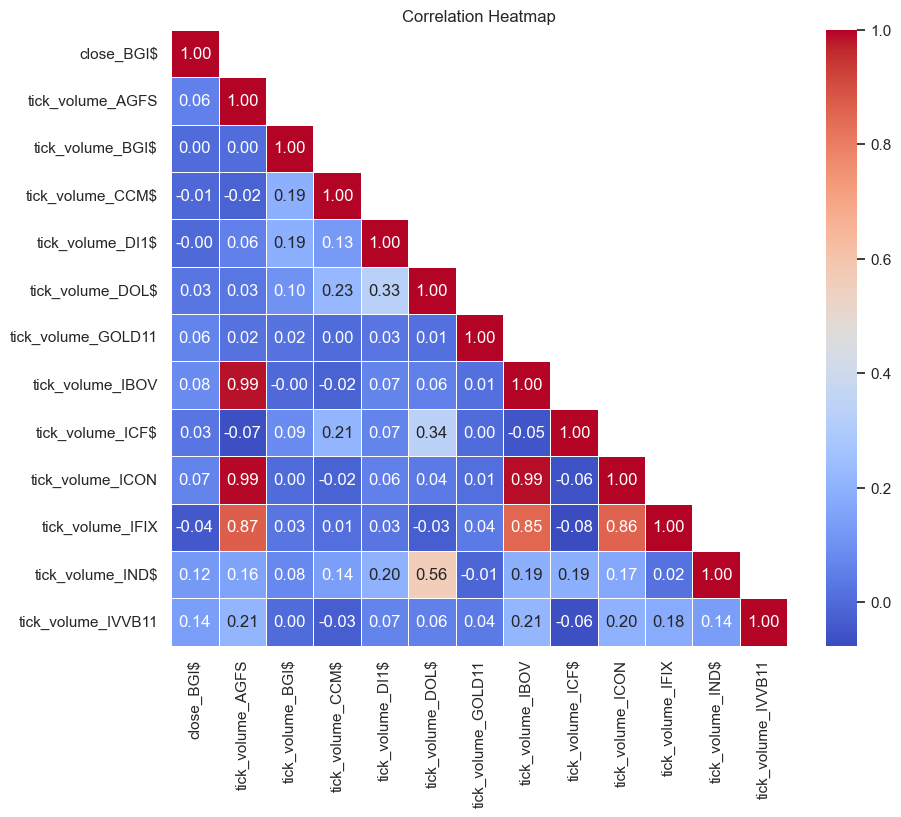

In [93]:
plot_correlation_matrix(df_scaled[tick_volume_columns])

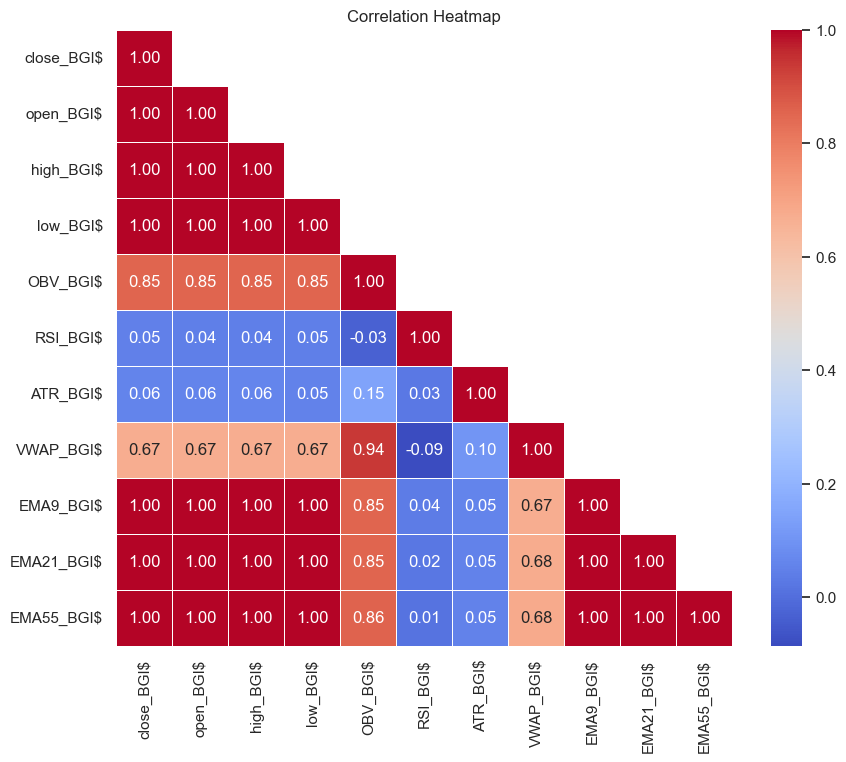

In [95]:
plot_correlation_matrix(df_scaled[bgi_indicators_columns])

In [96]:
df_scaled.columns

Index(['time', 'open_AGFS', 'high_AGFS', 'low_AGFS', 'close_AGFS',
       'tick_volume_AGFS', 'spread_AGFS', 'real_volume_AGFS', 'open_BGI$',
       'high_BGI$',
       ...
       'EMA55_GOLD11', 'EMA9_IBOV', 'EMA21_IBOV', 'EMA55_IBOV', 'EMA9_DOL$',
       'EMA21_DOL$', 'EMA55_DOL$', 'close_price_target', 'open_price_target',
       'behavior_target'],
      dtype='object', length=172)

In [114]:
correlation = df_scaled[['close_BGI$', 'tick_volume_BGI$']].corr()
print(correlation)

                  close_BGI$  tick_volume_BGI$
close_BGI$          1.000000          0.000737
tick_volume_BGI$    0.000737          1.000000


In [113]:
df_diff['mean_bgi'] = df_scaled['close_BGI$'].mean()

In [ ]:
df_diff['mean_'] = df_scaled['close_BGI$'].mean()